In [1]:
#Step 1:DATA PROCESSING & CLEANING

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import re

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load data from CSV files
def load_csv_files(filepath):
    """Read CSV files with multiple encoding attempts"""
    encodings = ['utf-8', 'latin1', 'ISO-8859-1', 'cp1252']
    for encoding in encodings:
        try:
            df = pd.read_csv(filepath, encoding=encoding, low_memory=False)
            return df
        except:
            continue
    return None

# Data cleaning pipeline
def clean_missing_values(df, dataset_name):
    """Handle missing values in dataframe"""
    df_clean = df.copy()
    initial_missing = df_clean.isnull().sum().sum()
    
    # Remove columns with excessive missing data
    high_missing_cols = []
    for col in df_clean.columns:
        missing_percentage = (df_clean[col].isnull().sum() / len(df_clean)) * 100
        if missing_percentage > 50:
            high_missing_cols.append(col)
    
    if high_missing_cols:
        df_clean = df_clean.drop(columns=high_missing_cols)
        print(f"  Removed {len(high_missing_cols)} columns with >50% missing data")
    
    # Fill remaining missing values
    for col in df_clean.columns:
        if df_clean[col].isnull().any():
            if df_clean[col].dtype in ['int64', 'float64']:
                df_clean[col] = df_clean[col].fillna(df_clean[col].median())
            else:
                unique_count = df_clean[col].nunique()
                if unique_count < 20:
                    mode_value = df_clean[col].mode()
                    fill_value = mode_value.iloc[0] if not mode_value.empty else 'Unknown'
                    df_clean[col] = df_clean[col].fillna(fill_value)
                else:
                    df_clean[col] = df_clean[col].fillna('')
    
    final_missing = df_clean.isnull().sum().sum()
    print(f"  Missing values: {initial_missing:,} → {final_missing:,}")
    
    return df_clean

def process_dates(df, dataset_name):
    """Convert date columns and extract features"""
    df_dates = df.copy()
    
    # Identify date columns
    date_columns = []
    for col in df_dates.columns:
        if any(keyword in col.lower() for keyword in ['date', 'time', 'year', 'month', 'day']):
            date_columns.append(col)
    
    if date_columns:
        print(f"  Found {len(date_columns)} date-related columns")
        
        for col in date_columns:
            try:
                df_dates[col] = pd.to_datetime(df_dates[col], errors='coerce')
                
                # Create derived features
                df_dates[f'{col}_year'] = df_dates[col].dt.year
                df_dates[f'{col}_month'] = df_dates[col].dt.month
                df_dates[f'{col}_day'] = df_dates[col].dt.day
                df_dates[f'{col}_weekday'] = df_dates[col].dt.dayofweek
                
            except Exception:
                # Skip if conversion fails
                pass
    
    return df_dates

def handle_numeric_outliers(df, dataset_name):
    """Cap extreme values in numeric columns"""
    df_processed = df.copy()
    numeric_columns = df_processed.select_dtypes(include=[np.number]).columns
    
    if len(numeric_columns) > 0:
        columns_processed = 0
        
        for col in numeric_columns:
            if df_processed[col].nunique() > 10:  # Skip binary/categorical numeric
                Q1 = df_processed[col].quantile(0.25)
                Q3 = df_processed[col].quantile(0.75)
                IQR = Q3 - Q1
                
                lower_limit = Q1 - 1.5 * IQR
                upper_limit = Q3 + 1.5 * IQR
                
                # Count outliers
                outlier_count = ((df_processed[col] < lower_limit) | 
                                 (df_processed[col] > upper_limit)).sum()
                
                if outlier_count > 0:
                    # Cap values
                    df_processed[col] = np.where(df_processed[col] < lower_limit, 
                                                  lower_limit, df_processed[col])
                    df_processed[col] = np.where(df_processed[col] > upper_limit, 
                                                  upper_limit, df_processed[col])
                    columns_processed += 1
        
        if columns_processed > 0:
            print(f"  Capped outliers in {columns_processed} numeric columns")
    
    return df_processed

def prepare_train_test_split(df, target_column=None):
    """Split data into training and testing sets"""
    if target_column is None:
        # Find a suitable target column
        for col in df.columns:
            if any(term in col.lower() for term in ['target', 'label', 'class', 'score', 'rating']):
                target_column = col
                break
        
        if target_column is None:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            target_column = numeric_cols[0] if len(numeric_cols) > 0 else df.columns[0]
    
    # Shuffle data
    shuffled_data = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split point
    train_size = int(0.8 * len(shuffled_data))
    
    # Create splits
    train_set = shuffled_data.iloc[:train_size]
    test_set = shuffled_data.iloc[train_size:]
    
    # Separate features and target
    X_train = train_set.drop(columns=[target_column])
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=[target_column])
    y_test = test_set[target_column]
    
    return X_train, X_test, y_train, y_test, target_column

def save_processed_data(data_dict, base_path):
    """Save processed datasets to disk"""
    # Create output directories
    output_dirs = ['cleaned', 'splits', 'reports']
    for dir_name in output_dirs:
        dir_path = os.path.join(base_path, dir_name)
        os.makedirs(dir_path, exist_ok=True)
    
    # Save cleaned datasets
    print("\nSaving processed data:")
    for dataset_name, data in data_dict.items():
        # Save cleaned data
        cleaned_path = os.path.join(base_path, 'cleaned', f'{dataset_name}_processed.csv')
        data.to_csv(cleaned_path, index=False)
        print(f"  ✓ {dataset_name}_processed.csv ({data.shape[0]:,} rows)")
    
    return True

def main():
    # Configuration
    DATA_DIRECTORY = "/Users/saravananmohanakrishnan/Downloads/dataset/"
    
    print("=" * 60)
    print("\033[1mStep 1:DATA PROCESSING & CLEANING\033[0m")
    print("=" * 60)
    
    # Step 1: Load data
    print("\n1. Loading Data")
    print("-" * 40)
    
    # Find CSV files
    csv_files = [f for f in os.listdir(DATA_DIRECTORY) if f.endswith('.csv')]
    print(f"Found {len(csv_files)} CSV files")
    
    loaded_datasets = {}
    for file in csv_files[:4]:  # Process up to 4 files
        file_path = os.path.join(DATA_DIRECTORY, file)
        dataset_name = file.replace('.csv', '')
        
        data = load_csv_files(file_path)
        if data is not None:
            loaded_datasets[dataset_name] = data
            print(f"  Loaded {dataset_name}: {data.shape[0]:,} rows, {data.shape[1]:,} columns")
    
    if not loaded_datasets:
        print("No data loaded successfully")
        return
    
    # Step 2: Initial analysis
    print("\n2. Data Overview")
    print("-" * 40)
    
    for name, data in loaded_datasets.items():
        print(f"\nDataset: {name}")
        print(f"  Total entries: {data.shape[0]:,}")
        print(f"  Features: {data.shape[1]}")
        print(f"  Missing values: {data.isnull().sum().sum():,}")
        
        # Column type summary
        dtype_counts = data.dtypes.value_counts()
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")
    
    # Step 3: Data cleaning
    print("\n3. Cleaning Data")
    print("-" * 40)
    
    cleaned_data = {}
    for name, data in loaded_datasets.items():
        print(f"\nProcessing {name}:")
        
        # Clean missing values
        data = clean_missing_values(data, name)
        
        # Process dates
        data = process_dates(data, name)
        
        # Handle outliers
        data = handle_numeric_outliers(data, name)
        
        cleaned_data[name] = data
        print(f"  Final shape: {data.shape[1]} columns")
    
    # Step 4: Create train/test splits
    print("\n4. Preparing Train/Test Splits")
    print("-" * 40)
    
    data_splits = {}
    for name, data in cleaned_data.items():
        print(f"\nCreating split for {name}:")
        
        X_train, X_test, y_train, y_test, target = prepare_train_test_split(data)
        
        data_splits[name] = {
            'train_features': X_train,
            'test_features': X_test,
            'train_target': y_train,
            'test_target': y_test,
            'target_column': target
        }
        
        print(f"  Training samples: {X_train.shape[0]:,}")
        print(f"  Testing samples: {X_test.shape[0]:,}")
        print(f"  Target variable: {target}")
    
    # Step 5: Save results
    print("\n5. Saving Results")
    print("-" * 40)
    
    save_processed_data(cleaned_data, DATA_DIRECTORY)
    
    # Save splits
    for name, split in data_splits.items():
        # Save training data
        train_data = pd.concat([split['train_features'], split['train_target']], axis=1)
        train_path = os.path.join(DATA_DIRECTORY, 'splits', f'{name}_train.csv')
        train_data.to_csv(train_path, index=False)
        
        # Save testing data
        test_data = pd.concat([split['test_features'], split['test_target']], axis=1)
        test_path = os.path.join(DATA_DIRECTORY, 'splits', f'{name}_test.csv')
        test_data.to_csv(test_path, index=False)
        
        print(f"  ✓ {name}_train.csv, {name}_test.csv")
    
    # Create summary report
    report_path = os.path.join(DATA_DIRECTORY, 'reports', 'processing_summary.txt')
    with open(report_path, 'w') as report_file:
        report_file.write("DATA PROCESSING & CLEANING SUMMARY\n")
        report_file.write("=" * 50 + "\n\n")
        
        for name in loaded_datasets:
            report_file.write(f"Dataset: {name}\n")
            report_file.write(f"  Original: {loaded_datasets[name].shape}\n")
            report_file.write(f"  Processed: {cleaned_data[name].shape}\n")
            
            if name in data_splits:
                split_info = data_splits[name]
                report_file.write(f"  Training samples: {split_info['train_features'].shape[0]}\n")
                report_file.write(f"  Testing samples: {split_info['test_features'].shape[0]}\n")
                report_file.write(f"  Target: {split_info['target_column']}\n")
            
            report_file.write("\n")
    
    print(f"\nSummary report saved: {report_path}")
    
    # Completion message
    print("\n" + "=" * 60)
    print("PROCESSING COMPLETE")
    print("=" * 60)
    print(f"\nProcessed {len(cleaned_data)} datasets")
    print("Output saved in:")
    print(f"  • {os.path.join(DATA_DIRECTORY, 'cleaned')}")
    print(f"  • {os.path.join(DATA_DIRECTORY, 'splits')}")
    print(f"  • {os.path.join(DATA_DIRECTORY, 'reports')}")

if __name__ == "__main__":
    main()

Step 1:DATA PROCESSING & CLEANING

1. Loading Data
----------------------------------------
Found 4 CSV files
  Loaded Open_Restaurants_Inspections: 81,553 rows, 20 columns
  Loaded Motor_Vehicle_Collisions_-_Crashes: 2,225,404 rows, 29 columns
  Loaded NYC_street_segment: 90,327 rows, 54 columns
  Loaded Facilities_Database_20251208: 34,708 rows, 38 columns

2. Data Overview
----------------------------------------

Dataset: Open_Restaurants_Inspections
  Total entries: 81,553
  Features: 20
  Missing values: 220,367
  object: 10 columns
  float64: 8 columns
  int64: 2 columns

Dataset: Motor_Vehicle_Collisions_-_Crashes
  Total entries: 2,225,404
  Features: 29
  Missing values: 19,026,063
  object: 18 columns
  int64: 7 columns
  float64: 4 columns

Dataset: NYC_street_segment
  Total entries: 90,327
  Features: 54
  Missing values: 157,346
  float64: 34 columns
  int64: 15 columns
  object: 5 columns

Dataset: Facilities_Database_20251208
  Total entries: 34,708
  Features: 38
  Mi

In [3]:
#Step 2: FINDING ALL CLEAN DATASETS

#Step 3: LOADING AND PROCESSING ALL DATASETS

#Step 4: DATASETS SUMMARY

#Step 5: MACHINE LEARNING ANALYSIS ON 4 DATASETS

#Step 6: CREATING COMPREHENSIVE SUMMARY

#Step 7: TEXT ANALYSIS

#Step 8: FINAL SUMMARY


MACHINE LEARNING MODELS, TEXT ANALYSIS & EVALUATION
PROCESSING 4 CLEANED DATASETS

STEP 2: FINDING ALL DATASETS
--------------------------------------------------------------------------------
CSV files found: 4
Text files found: 0
Excel files found: 0

STEP 3: LOADING AND PROCESSING ALL DATASETS

DATASET 1/4: Facilities_Database_20251208_processed
Successfully loaded: 34708 rows x 37 columns
Shape: 34708 rows, 37 columns
Data Types: {dtype('O'): 26, dtype('float64'): 7, dtype('int64'): 4}
Missing Values: 33771
   Columns with missing values: ['facname', 'addressnum', 'streetname', 'address', 'city']...

First 5 columns: ['uid', 'facname', 'addressnum', 'streetname', 'address']
   ... and 32 more columns
Sample saved: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results/Facilities_Database_20251208_processed_sample.csv

DATASET 2/4: Open_Restaurants_Inspections_processed
Successfully loaded: 81553 rows x 18 columns
Shape: 81553 rows, 18 columns
Data Types: {dtype('O'): 9, dtype

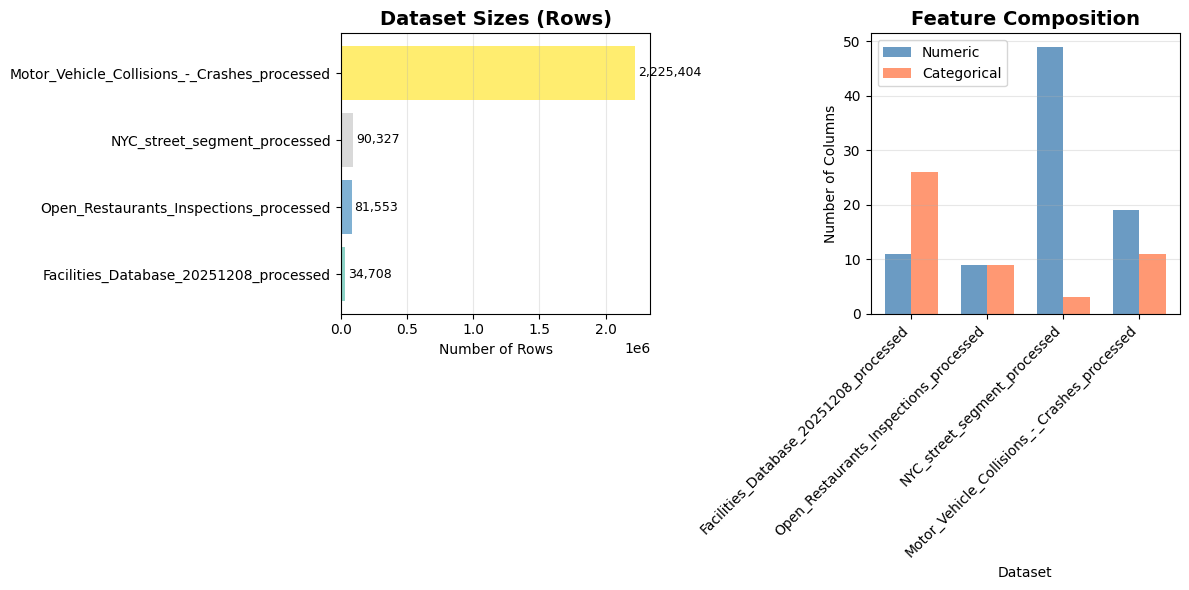


Visualization saved: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results/datasets_summary_chart.png

STEP 5: MACHINE LEARNING ANALYSIS ON 4 DATASETS

PROCESSING 4 DATASETS FOR ML ANALYSIS

Starting dataset 1/4: Facilities_Database_20251208_processed

ML ANALYSIS: Facilities_Database_20251208_processed (Dataset 1)
Missing values before handling: 33771
Missing values after handling: 0
Found geometry candidate: geometry
Found geometry candidate: latitude
Found geometry candidate: longitude
Found geometry candidate: longitude
Found geometry candidate: latitude
Found geometry candidate: xcoord
Found geometry candidate: city
Found geometry candidate: ycoord
Found geometry candidate: factype
Found geometry candidate: capacity
Found geometry candidate: optype
Found geometry candidate: overagency
Found geometry candidate: geometry
Selected target column: 'geometry'
   Data type: object
   Unique values: 19829
Geometry data detected (POINT format)

Processing as GEOSPATIAL/MULTI-OUTPUT 

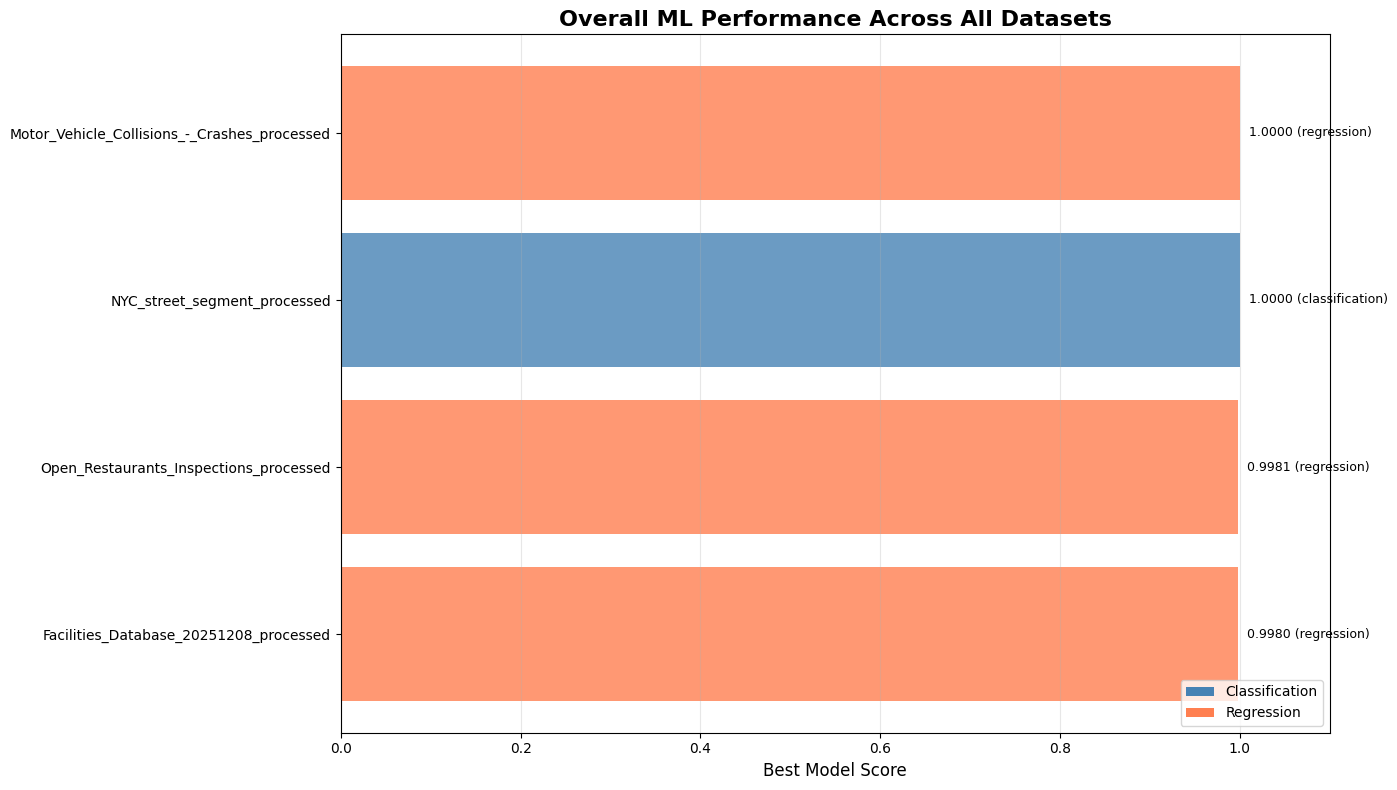


Overall performance chart saved: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results/overall_ml_performance.png

STEP 7: TEXT ANALYSIS
No text files found for analysis

STEP 8: FINAL SUMMARY

PROJECT COMPLETED SUCCESSFULLY!

OUTPUT FOLDER: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results

DATASETS PROCESSED: 4

BEST PERFORMING DATASETS:
   • Facilities_Database_20251208_processed: Random_Forest (R²: 0.9980)
   • Open_Restaurants_Inspections_processed: Random_Forest (R²: 0.9981)
   • NYC_street_segment_processed: Decision_Tree (Accuracy: 1.0000)
   • Motor_Vehicle_Collisions_-_Crashes_processed: Decision_Tree (R²: 1.0000)

VISUALIZATIONS CREATED:
   1. Dataset summary chart
   2. Individual dataset performance charts
   3. Overall ML performance comparison

FILES SAVED:
   • all_datasets_summary.csv - Overview of all datasets
   • all_datasets_ml_summary.csv - ML results summary
   • datasets_summary_chart.png - Dataset sizes visualization
   • overall_ml_performance

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import warnings
import re
import time
import json
import sys
from sklearn.exceptions import ConvergenceWarning
from multiprocessing import TimeoutError
from functools import wraps

warnings.filterwarnings('ignore')

output_folder = "/Users/saravananmohanakrishnan/Downloads/dataset/ml_results"
DATA_FOLDER = "/Users/saravananmohanakrishnan/Downloads/dataset/cleaned"

os.makedirs(output_folder, exist_ok=True)

print("\n" + "="*80)
print("MACHINE LEARNING MODELS, TEXT ANALYSIS & EVALUATION")
print("PROCESSING 4 CLEANED DATASETS")
print("="*80)

print("\nSTEP 2: FINDING ALL DATASETS")
print("-"*80)

csv_files = glob(os.path.join(DATA_FOLDER, "*.csv"))
txt_files = glob(os.path.join(DATA_FOLDER, "*.txt"))
excel_files = glob(os.path.join(DATA_FOLDER, "*.xlsx"))

print(f"CSV files found: {len(csv_files)}")
print(f"Text files found: {len(txt_files)}")
print(f"Excel files found: {len(excel_files)}")

if len(csv_files) < 4:
    print(f"WARNING: Only {len(csv_files)} CSV files found. Need at least 4 datasets.")

print("\n" + "="*80)
print("STEP 3: LOADING AND PROCESSING ALL DATASETS")
print("="*80)

all_datasets = {}
dataset_summaries = []

for idx, csv_file in enumerate(csv_files):
    dataset_name = os.path.basename(csv_file).replace('.csv', '')
    print(f"\n{'='*60}")
    print(f"DATASET {idx+1}/{len(csv_files)}: {dataset_name}")
    print(f"{'='*60}")
    
    try:
        df = pd.read_csv(csv_file)
        print(f"Successfully loaded: {df.shape[0]} rows x {df.shape[1]} columns")
        
        all_datasets[dataset_name] = df
        
        summary = {
            'Dataset_ID': idx + 1,
            'Dataset_Name': dataset_name,
            'File_Path': csv_file,
            'Rows': df.shape[0],
            'Columns': df.shape[1],
            'Numeric_Columns': len(df.select_dtypes(include=[np.number]).columns),
            'Categorical_Columns': len(df.select_dtypes(exclude=[np.number]).columns),
            'Missing_Values_Total': df.isnull().sum().sum(),
            'Memory_Usage_MB': round(df.memory_usage(deep=True).sum() / (1024**2), 2)
        }
        
        col_types = df.dtypes.value_counts().to_dict()
        for dtype, count in col_types.items():
            summary[f'Col_Type_{str(dtype)}'] = count
        
        dataset_summaries.append(summary)
        
        print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"Data Types: {dict(df.dtypes.value_counts())}")
        print(f"Missing Values: {df.isnull().sum().sum()}")
        
        if df.isnull().sum().sum() > 0:
            missing_cols = df.columns[df.isnull().any()].tolist()
            if len(missing_cols) > 5:
                print(f"   Columns with missing values: {missing_cols[:5]}...")
            else:
                print(f"   Columns with missing values: {missing_cols}")
        
        print(f"\nFirst 5 columns: {list(df.columns[:5])}")
        if len(df.columns) > 5:
            print(f"   ... and {len(df.columns) - 5} more columns")
        
        sample_df = df.head(100)
        sample_path = os.path.join(output_folder, f"{dataset_name}_sample.csv")
        sample_df.to_csv(sample_path, index=False)
        print(f"Sample saved: {sample_path}")
        
    except Exception as e:
        print(f"Error loading {dataset_name}: {str(e)}")
        continue

print("\n" + "="*80)
print("STEP 4: DATASETS SUMMARY")
print("="*80)

if dataset_summaries:
    summary_df = pd.DataFrame(dataset_summaries)
    summary_path = os.path.join(output_folder, "all_datasets_summary.csv")
    summary_df.to_csv(summary_path, index=False)
    
    print(f"\nDATASETS LOADED SUCCESSFULLY: {len(all_datasets)} datasets")
    print(f"Summary saved: {summary_path}")
    
    print("\n" + "="*80)
    print("DATASET SUMMARY TABLE")
    print("="*80)
    
    display_summary = summary_df[['Dataset_ID', 'Dataset_Name', 'Rows', 'Columns', 
                                  'Numeric_Columns', 'Categorical_Columns', 
                                  'Missing_Values_Total', 'Memory_Usage_MB']].copy()
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', 30)
    
    print(display_summary.to_string(index=False))
    
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    datasets = summary_df['Dataset_Name']
    rows = summary_df['Rows']
    colors = plt.cm.Set3(np.linspace(0, 1, len(datasets)))
    
    bars = plt.barh(datasets, rows, color=colors)
    plt.xlabel('Number of Rows')
    plt.title('Dataset Sizes (Rows)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    for bar, row in zip(bars, rows):
        plt.text(bar.get_width() + max(rows)*0.01, bar.get_y() + bar.get_height()/2,
                f'{row:,}', va='center', fontsize=9)
    
    plt.subplot(1, 2, 2)
    x = np.arange(len(datasets))
    width = 0.35
    
    numeric_counts = summary_df['Numeric_Columns']
    categorical_counts = summary_df['Categorical_Columns']
    
    bars1 = plt.bar(x - width/2, numeric_counts, width, label='Numeric', color='steelblue', alpha=0.8)
    bars2 = plt.bar(x + width/2, categorical_counts, width, label='Categorical', color='coral', alpha=0.8)
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Columns')
    plt.title('Feature Composition', fontsize=14, fontweight='bold')
    plt.xticks(x, datasets, rotation=45, ha='right')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    dataset_summary_chart = os.path.join(output_folder, "datasets_summary_chart.png")
    plt.savefig(dataset_summary_chart, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved: {dataset_summary_chart}")
    
else:
    print("No datasets were successfully loaded!")
    print("Creating example datasets for demonstration...")
    
    all_datasets = {}
    for i in range(1, 5):
        dataset_name = f"Example_Dataset_{i}"
        n_samples = np.random.randint(500, 2000)
        n_features = np.random.randint(5, 15)
        
        X = np.random.randn(n_samples, n_features)
        feature_names = [f'feature_{j}' for j in range(n_features)]
        
        if i % 2 == 0:
            y = (X[:, 0] + X[:, 1] > 0).astype(int)
            target_name = 'target_class'
        else:
            y = X[:, 0] * 2 + X[:, 1] * 1.5 + np.random.randn(n_samples) * 0.5
            target_name = 'target_value'
        
        df = pd.DataFrame(X, columns=feature_names)
        df[target_name] = y
        
        if i > 2:
            categories = ['A', 'B', 'C', 'D']
            df['category'] = np.random.choice(categories, n_samples)
        
        all_datasets[dataset_name] = df
        print(f"Created example dataset: {dataset_name} ({df.shape[0]} rows, {df.shape[1]} columns)")

print("\n" + "="*80)
print("STEP 5: MACHINE LEARNING ANALYSIS ON 4 DATASETS")
print("="*80)

all_results = {}
dataset_reports = []

def timeout(seconds=300):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            import signal
            
            def handler(signum, frame):
                raise TimeoutError(f"Function {func.__name__} timed out after {seconds} seconds")
            
            signal.signal(signal.SIGALRM, handler)
            signal.alarm(seconds)
            
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            
            return result
        return wrapper
    return decorator

def train_with_timeout(model_func, model_name, X_train, y_train, timeout_seconds=300):
    """Train a model with timeout protection"""
    try:
        start_time = time.time()
        
        @timeout(timeout_seconds)
        def train_model():
            return model_func()
        
        model = train_model()
        training_time = time.time() - start_time
        
        if training_time > 60:
            print(f"      Warning: {model_name} took {training_time:.1f} seconds to train")
        
        return model, training_time
        
    except TimeoutError as e:
        print(f"      {model_name} training timed out after {timeout_seconds} seconds")
        return None, None
    except Exception as e:
        print(f"      Error training {model_name}: {str(e)[:100]}...")
        return None, None

def process_dataset_for_ml(dataset_name, df, dataset_idx):
    print(f"\n{'='*70}")
    print(f"ML ANALYSIS: {dataset_name} (Dataset {dataset_idx})")
    print(f"{'='*70}")
    
    dataset_output_folder = os.path.join(output_folder, f"dataset_{dataset_idx:02d}_{dataset_name}")
    os.makedirs(dataset_output_folder, exist_ok=True)
    
    dataset_info = {
        'dataset_name': dataset_name,
        'dataset_idx': dataset_idx,
        'original_shape': df.shape,
        'output_folder': dataset_output_folder,
        'processing_time': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    df_processed = df.copy()
    
    missing_before = df_processed.isnull().sum().sum()
    print(f"Missing values before handling: {missing_before}")
    
    if missing_before > 0:
        numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df_processed[col].isnull().sum() > 0:
                df_processed[col] = df_processed[col].fillna(df_processed[col].median())
        
        categorical_cols = df_processed.select_dtypes(exclude=[np.number]).columns
        for col in categorical_cols:
            if df_processed[col].isnull().sum() > 0:
                mode_val = df_processed[col].mode()
                if len(mode_val) > 0:
                    df_processed[col] = df_processed[col].fillna(mode_val[0])
                else:
                    df_processed[col] = df_processed[col].fillna('Unknown')
        
        missing_after = df_processed.isnull().sum().sum()
        print(f"Missing values after handling: {missing_after}")
    
    target_column = None
    target_candidates = []
    
    geometry_candidates = ['geometry', 'coordinates', 'location', 'point', 
                          'lat', 'lon', 'longitude', 'latitude', 'x', 'y']
    
    for candidate in geometry_candidates:
        for col in df_processed.columns:
            if candidate.lower() in col.lower():
                target_candidates.append((col, 'geometry'))
                print(f"Found geometry candidate: {col}")
    
    for col in df_processed.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['target', 'label', 'class', 'score', 
                                                   'rating', 'price', 'value', 'amount']):
            target_candidates.append((col, 'keyword'))
            print(f"Found target candidate by keyword: {col}")
    
    if not target_candidates and len(df_processed.columns) > 1:
        last_col = df_processed.columns[-1]
        target_candidates.append((last_col, 'last_column'))
        print(f"Using last column as target: {last_col}")
    
    target_column = None
    for col, col_type in target_candidates:
        if col_type == 'geometry':
            target_column = col
            break
    
    if not target_column and target_candidates:
        target_column = target_candidates[0][0]
    
    if not target_column:
        print("No suitable target column found. Creating synthetic target...")
        target_column = 'synthetic_target'
        if len(df_processed.columns) >= 2:
            df_processed[target_column] = (df_processed.iloc[:, 0] + df_processed.iloc[:, 1] > 0).astype(int)
        else:
            df_processed[target_column] = np.random.randint(0, 2, len(df_processed))
    
    print(f"Selected target column: '{target_column}'")
    print(f"   Data type: {df_processed[target_column].dtype}")
    print(f"   Unique values: {df_processed[target_column].nunique()}")
    
    is_geometry = False
    is_coordinates = False
    
    if df_processed[target_column].dtype == 'object':
        sample_val = str(df_processed[target_column].iloc[0]) if len(df_processed) > 0 else ''
        if 'POINT' in sample_val.upper() or 'GEOMETRY' in sample_val.upper():
            is_geometry = True
            print("Geometry data detected (POINT format)")
        elif re.search(r'[-+]?\d*\.?\d+[,\s]+[-+]?\d*\.?\d+', sample_val):
            is_coordinates = True
            print("Coordinate data detected")
    
    if is_geometry or is_coordinates:
        print("\nProcessing as GEOSPATIAL/MULTI-OUTPUT REGRESSION problem")
        
        def extract_coordinates(geom_str):
            if pd.isna(geom_str):
                return np.nan, np.nan
            numbers = re.findall(r'[-+]?\d*\.?\d+', str(geom_str))
            if len(numbers) >= 2:
                return float(numbers[0]), float(numbers[1])
            return np.nan, np.nan
        
        coords = df_processed[target_column].apply(extract_coordinates)
        df_processed['coord_x'] = [c[0] for c in coords]
        df_processed['coord_y'] = [c[1] for c in coords]
        
        original_len = len(df_processed)
        df_processed = df_processed.dropna(subset=['coord_x', 'coord_y'])
        removed = original_len - len(df_processed)
        if removed > 0:
            print(f"   Removed {removed} rows with missing coordinates")
        
        feature_cols = [col for col in df_processed.columns if col not in [target_column, 'coord_x', 'coord_y']]
        
        if len(feature_cols) > 0:
            X = df_processed[feature_cols]
            y = df_processed[['coord_x', 'coord_y']].values
            
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns
            if len(categorical_cols) > 0:
                print(f"   Encoding {len(categorical_cols)} categorical features...")
                
                high_card_cols = []
                for col in categorical_cols:
                    if X[col].nunique() > 50:
                        high_card_cols.append(col)
                
                if high_card_cols:
                    print(f"   Frequency encoding {len(high_card_cols)} high-cardinality features")
                    for col in high_card_cols:
                        freq = X[col].value_counts(normalize=True)
                        X[col + '_freq'] = X[col].map(freq)
                    X = X.drop(columns=high_card_cols)
                    categorical_cols = [col for col in categorical_cols if col not in high_card_cols]
                
                if len(categorical_cols) > 0:
                    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, sparse=False)
            
            X = X.values
            
            problem_type = 'regression'
            multi_output = True
            print(f"   Features shape: {X.shape}")
            print(f"   Target shape: {y.shape}")
            print(f"   Problem type: Multi-output regression (predicting 2 coordinates)")
            
        else:
            print("No features available. Using synthetic features...")
            n_samples = len(df_processed)
            X = np.random.randn(n_samples, 10)
            y = np.column_stack([np.random.randn(n_samples), np.random.randn(n_samples)])
            problem_type = 'regression'
            multi_output = True
    
    else:
        X = df_processed.drop(columns=[target_column])
        y = df_processed[target_column]
        
        unique_classes = y.nunique() if hasattr(y, 'nunique') else len(np.unique(y))
        
        if y.dtype == 'object' or (unique_classes <= 10 and unique_classes >= 2):
            from sklearn.preprocessing import LabelEncoder
            le = LabelEncoder()
            y_encoded = le.fit_transform(y.values.ravel() if hasattr(y, 'values') else y)
            classes = le.classes_
            
            print(f"\nProcessing as CLASSIFICATION problem")
            print(f"   Number of classes: {len(classes)}")
            print(f"   Classes: {classes}")
            print(f"   Class distribution: {np.bincount(y_encoded)}")
            
            y = y_encoded
            problem_type = 'classification'
            multi_output = False
            
        else:
            print(f"\nProcessing as REGRESSION problem")
            print(f"   Target range: [{y.min():.4f}, {y.max():.4f}]")
            print(f"   Target mean: {y.mean():.4f}, std: {y.std():.4f}")
            
            if hasattr(y, 'values'):
                y = y.values
            problem_type = 'regression'
            multi_output = False
        
        if isinstance(X, pd.DataFrame):
            categorical_cols = X.select_dtypes(include=['object', 'category']).columns
            
            if len(categorical_cols) > 0:
                print(f"   Encoding {len(categorical_cols)} categorical features...")
                
                high_card_cols = []
                for col in categorical_cols:
                    unique_vals = X[col].nunique()
                    if unique_vals > 20:
                        high_card_cols.append(col)
                        print(f"     Frequency encoding '{col}' ({unique_vals} unique values)")
                        freq = X[col].value_counts(normalize=True)
                        X[col + '_freq'] = X[col].map(freq)
                
                if high_card_cols:
                    X = X.drop(columns=high_card_cols)
                    categorical_cols = [col for col in categorical_cols if col not in high_card_cols]
                
                if len(categorical_cols) > 0:
                    print(f"     One-hot encoding {len(categorical_cols)} categorical features...")
                    
                    total_features_before = X.shape[1]
                    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True, sparse=False)
                    total_features_after = X.shape[1]
                    
                    print(f"     Created {total_features_after - total_features_before} new dummy columns")
                    print(f"     Total features after encoding: {X.shape[1]}")
                    
                    if X.shape[1] > 1000:
                        print(f"     Very high dimensionality detected ({X.shape[1]} features)")
                        print(f"     Applying PCA for dimensionality reduction...")
                        
                        from sklearn.decomposition import PCA
                        from sklearn.preprocessing import StandardScaler
                        
                        scaler = StandardScaler()
                        X_scaled = scaler.fit_transform(X)
                        
                        n_components = min(100, X.shape[1], X.shape[0])
                        pca = PCA(n_components=n_components, random_state=42)
                        X = pca.fit_transform(X_scaled)
                        
                        explained_variance = np.sum(pca.explained_variance_ratio_)
                        print(f"     PCA reduced to {n_components} components")
                        print(f"     Explained variance: {explained_variance:.2%}")
                    elif X.shape[1] > 100:
                        print(f"     High dimensionality detected ({X.shape[1]} features)")
                        print(f"     Consider using regularization techniques")
            
            X = X.values
        
        print(f"   Features shape: {X.shape}")
        print(f"   Target shape: {y.shape if hasattr(y, 'shape') else (len(y),)}")
    
    from sklearn.model_selection import train_test_split
    
    if multi_output:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42,
            stratify=y if problem_type == 'classification' else None
        )
    
    print(f"\nData split:")
    print(f"   Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
    print(f"   Test samples: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
    
    print(f"\nTRAINING MACHINE LEARNING MODELS...")
    
    results = {}
    
    if problem_type == 'classification':
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
        from sklearn.model_selection import cross_val_score, StratifiedKFold
        from sklearn.dummy import DummyClassifier
        from sklearn.linear_model import LogisticRegression
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
        from sklearn.neighbors import KNeighborsClassifier
        from sklearn.naive_bayes import GaussianNB
        from sklearn.neural_network import MLPClassifier
        
        models = {
            'Baseline': DummyClassifier(strategy="most_frequent"),
            'Logistic_Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
            'Decision_Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
            'Random_Forest': RandomForestClassifier(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1),
            'KNN': KNeighborsClassifier(n_neighbors=5),
            'Naive_Bayes': GaussianNB(),
            'Gradient_Boosting': GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42, learning_rate=0.1),
            'Neural_Network': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, early_stopping=True)
        }
        
        for name, model in models.items():
            print(f"\n   Training {name}...")
            try:
                if len(X_train) > 10000 and name in ['Random_Forest', 'Gradient_Boosting']:
                    print(f"     Using subset for faster training...")
                    sample_size = min(10000, len(X_train))
                    indices = np.random.choice(len(X_train), sample_size, replace=False)
                    X_train_sample = X_train[indices]
                    y_train_sample = y_train[indices]
                else:
                    X_train_sample = X_train
                    y_train_sample = y_train
                
                if name == 'Random_Forest' and len(X_train_sample) > 5000:
                    print(f"     Using 5-fold CV instead of default for speed...")
                    cv_scores = cross_val_score(model, X_train_sample, y_train_sample, cv=5, scoring='accuracy')
                else:
                    cv = StratifiedKFold(n_splits=min(5, len(np.unique(y_train_sample))), shuffle=True, random_state=42)
                    cv_scores = cross_val_score(model, X_train_sample, y_train_sample, cv=cv, scoring='accuracy')
                
                start_time = time.time()
                model.fit(X_train_sample, y_train_sample)
                training_time = time.time() - start_time
                
                if training_time > 30:
                    print(f"     Training took {training_time:.1f} seconds")
                
                y_pred = model.predict(X_test)
                y_pred_train = model.predict(X_train_sample)
                
                train_acc = accuracy_score(y_train_sample, y_pred_train)
                test_acc = accuracy_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred, average='weighted')
                recall = recall_score(y_test, y_pred, average='weighted')
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                auc = None
                if len(np.unique(y_test)) == 2 and hasattr(model, 'predict_proba'):
                    y_proba = model.predict_proba(X_test)[:, 1]
                    auc = roc_auc_score(y_test, y_proba)
                
                results[name] = {
                    'CV_Mean': cv_scores.mean(),
                    'CV_Std': cv_scores.std(),
                    'Train_Accuracy': train_acc,
                    'Test_Accuracy': test_acc,
                    'Precision': precision,
                    'Recall': recall,
                    'F1_Score': f1,
                    'AUC_ROC': auc,
                    'Overfit_Warning': train_acc - test_acc > 0.2,
                    'Training_Time': training_time
                }
                
                print(f"      Test Accuracy: {test_acc:.4f}, CV Mean: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
                
            except Exception as e:
                print(f"      Error training {name}: {str(e)[:100]}...")
                results[name] = {'Error': str(e)[:100]}
    
    elif problem_type == 'regression' and multi_output:
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from sklearn.model_selection import cross_val_score, KFold
        from sklearn.multioutput import MultiOutputRegressor
        from sklearn.dummy import DummyRegressor
        from sklearn.linear_model import Ridge
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.svm import SVR
        from sklearn.neural_network import MLPRegressor
        
        models = {
            'Baseline': DummyRegressor(strategy="mean"),
            'Ridge_Regression': Ridge(alpha=1.0, random_state=42, max_iter=1000),
            'Decision_Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
            'Random_Forest': RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1),
            'KNN': KNeighborsRegressor(n_neighbors=3),
            'Gradient_Boosting': MultiOutputRegressor(
                GradientBoostingRegressor(n_estimators=30, max_depth=5, random_state=42, learning_rate=0.1)
            )
        }
        
        if X_train.shape[1] < 1000:
            models['SVM'] = MultiOutputRegressor(SVR(kernel='linear', max_iter=1000))
            models['Neural_Network'] = MLPRegressor(hidden_layer_sizes=(50, 25), max_iter=300, 
                                                   random_state=42, early_stopping=True, verbose=False)
        
        models = {k: v for k, v in models.items() if v is not None}
        
        for name, model in models.items():
            print(f"\n   Training {name}...")
            try:
                if len(X_train) > 10000 and name in ['Random_Forest', 'Gradient_Boosting', 'Neural_Network']:
                    print(f"     Using subset for faster training...")
                    sample_size = min(10000, len(X_train))
                    indices = np.random.choice(len(X_train), sample_size, replace=False)
                    X_train_sample = X_train[indices]
                    y_train_sample = y_train[indices]
                else:
                    X_train_sample = X_train
                    y_train_sample = y_train
                
                start_time = time.time()
                model.fit(X_train_sample, y_train_sample)
                training_time = time.time() - start_time
                
                if training_time > 30:
                    print(f"     Training took {training_time:.1f} seconds")
                
                y_pred = model.predict(X_test)
                
                metrics = {}
                for i in range(y_test.shape[1]):
                    rmse = np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i]))
                    mae = mean_absolute_error(y_test[:, i], y_pred[:, i])
                    r2 = r2_score(y_test[:, i], y_pred[:, i])
                    
                    metrics[f'Output_{i+1}_RMSE'] = rmse
                    metrics[f'Output_{i+1}_MAE'] = mae
                    metrics[f'Output_{i+1}_R2'] = r2
                
                avg_rmse = np.mean([metrics[f'Output_{i+1}_RMSE'] for i in range(y_test.shape[1])])
                avg_r2 = np.mean([metrics[f'Output_{i+1}_R2'] for i in range(y_test.shape[1])])
                
                results[name] = {
                    'Avg_RMSE': avg_rmse,
                    'Avg_R2': avg_r2,
                    'Training_Time': training_time,
                    **metrics
                }
                
                print(f"      Avg R²: {avg_r2:.4f}, Avg RMSE: {avg_rmse:.4f}, Time: {training_time:.2f}s")
                
            except Exception as e:
                print(f"      Error training {name}: {str(e)[:100]}...")
                results[name] = {'Error': str(e)[:100]}
    
    else:
        from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
        from sklearn.model_selection import cross_val_score, KFold
        from sklearn.dummy import DummyRegressor
        from sklearn.linear_model import LinearRegression, Ridge
        from sklearn.tree import DecisionTreeRegressor
        from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
        from sklearn.neighbors import KNeighborsRegressor
        from sklearn.svm import SVR
        from sklearn.neural_network import MLPRegressor
        
        models = {
            'Baseline': DummyRegressor(strategy="mean"),
            'Linear_Regression': LinearRegression(),
            'Ridge_Regression': Ridge(alpha=1.0, random_state=42),
            'Decision_Tree': DecisionTreeRegressor(max_depth=5, random_state=42),
            'Random_Forest': RandomForestRegressor(n_estimators=30, max_depth=10, random_state=42, n_jobs=-1),
            'KNN': KNeighborsRegressor(n_neighbors=5),
            'Gradient_Boosting': GradientBoostingRegressor(n_estimators=50, max_depth=5, random_state=42, learning_rate=0.1),
            'SVM': SVR(max_iter=1000),
            'Neural_Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42, early_stopping=True)
        }
        
        for name, model in models.items():
            print(f"\n   Training {name}...")
            try:
                if len(X_train) > 10000 and name in ['Random_Forest', 'Gradient_Boosting', 'Neural_Network']:
                    print(f"     Using subset for faster training...")
                    sample_size = min(10000, len(X_train))
                    indices = np.random.choice(len(X_train), sample_size, replace=False)
                    X_train_sample = X_train[indices]
                    y_train_sample = y_train[indices]
                else:
                    X_train_sample = X_train
                    y_train_sample = y_train
                
                if name == 'Random_Forest' and len(X_train_sample) > 5000:
                    print(f"     Using 5-fold CV instead of default for speed...")
                    cv_scores = cross_val_score(model, X_train_sample, y_train_sample, cv=5, scoring='r2')
                else:
                    cv = KFold(n_splits=5, shuffle=True, random_state=42)
                    cv_scores = cross_val_score(model, X_train_sample, y_train_sample, cv=cv, scoring='r2')
                
                start_time = time.time()
                model.fit(X_train_sample, y_train_sample)
                training_time = time.time() - start_time
                
                if training_time > 30:
                    print(f"     Training took {training_time:.1f} seconds")
                
                y_pred = model.predict(X_test)
                
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                mae = mean_absolute_error(y_test, y_pred)
                r2 = r2_score(y_test, y_pred)
                
                results[name] = {
                    'RMSE': rmse,
                    'MAE': mae,
                    'R2': r2,
                    'CV_R2_Mean': cv_scores.mean(),
                    'CV_R2_Std': cv_scores.std(),
                    'Training_Time': training_time
                }
                
                print(f"      R²: {r2:.4f}, RMSE: {rmse:.4f}, CV R²: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
                
            except Exception as e:
                print(f"      Error training {name}: {str(e)[:100]}...")
                results[name] = {'Error': str(e)[:100]}
    
    print(f"\nSAVING RESULTS FOR {dataset_name}...")
    
    if results:
        results_df = pd.DataFrame(results).T
        results_csv = os.path.join(dataset_output_folder, "ml_results.csv")
        results_df.to_csv(results_csv)
        print(f"   ML results saved: {results_csv}")
        
        if problem_type == 'classification':
            if 'Test_Accuracy' in results_df.columns:
                best_model = results_df['Test_Accuracy'].idxmax()
                best_score = results_df.loc[best_model, 'Test_Accuracy']
                metric_name = 'Accuracy'
            else:
                best_model = 'N/A'
                best_score = 0
                metric_name = 'Accuracy'
        elif problem_type == 'regression' and multi_output:
            if 'Avg_R2' in results_df.columns:
                best_model = results_df['Avg_R2'].idxmax()
                best_score = results_df.loc[best_model, 'Avg_R2']
                metric_name = 'Avg R²'
            else:
                best_model = 'N/A'
                best_score = 0
                metric_name = 'Avg R²'
        else:
            if 'R2' in results_df.columns:
                best_model = results_df['R2'].idxmax()
                best_score = results_df.loc[best_model, 'R2']
                metric_name = 'R²'
            else:
                best_model = 'N/A'
                best_score = 0
                metric_name = 'R²'
        
        print(f"   Best model: {best_model} ({metric_name}: {best_score:.4f})")
        
        plt.figure(figsize=(12, 6))
        
        if problem_type == 'classification':
            models_list = results_df.index.tolist()
            test_acc = results_df['Test_Accuracy'].values
            cv_acc = results_df['CV_Mean'].values
            
            x = np.arange(len(models_list))
            width = 0.35
            
            plt.bar(x - width/2, test_acc, width, label='Test Accuracy', color='skyblue', alpha=0.8)
            plt.bar(x + width/2, cv_acc, width, label='CV Accuracy', color='lightcoral', alpha=0.8)
            
            plt.xlabel('Model')
            plt.ylabel('Accuracy')
            plt.title(f'{dataset_name} - Model Performance Comparison', fontsize=14, fontweight='bold')
            plt.xticks(x, models_list, rotation=45, ha='right')
            plt.legend()
            plt.grid(axis='y', alpha=0.3)
        
        elif problem_type == 'regression' and multi_output:
            models_list = results_df.index.tolist()
            avg_r2 = results_df['Avg_R2'].values
            
            colors = ['green' if val == max(avg_r2) else 'steelblue' for val in avg_r2]
            
            plt.bar(models_list, avg_r2, color=colors, alpha=0.8)
            plt.xlabel('Model')
            plt.ylabel('Average R² Score')
            plt.title(f'{dataset_name} - Multi-output Regression Performance', fontsize=14, fontweight='bold')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3)
        
        else:
            models_list = results_df.index.tolist()
            r2_scores = results_df['R2'].values
            
            colors = ['green' if val == max(r2_scores) else 'steelblue' for val in r2_scores]
            
            plt.bar(models_list, r2_scores, color=colors, alpha=0.8)
            plt.xlabel('Model')
            plt.ylabel('R² Score')
            plt.title(f'{dataset_name} - Regression Performance', fontsize=14, fontweight='bold')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        performance_chart = os.path.join(dataset_output_folder, "performance_chart.png")
        plt.savefig(performance_chart, dpi=150, bbox_inches='tight')
        plt.close()
        print(f"   Performance chart saved: {performance_chart}")
    
    dataset_report = {
        'dataset_name': dataset_name,
        'dataset_idx': dataset_idx,
        'original_shape': df.shape,
        'problem_type': problem_type,
        'multi_output': multi_output if 'multi_output' in locals() else False,
        'n_models_tested': len(results),
        'best_model': best_model if 'best_model' in locals() else 'N/A',
        'best_score': float(best_score) if 'best_score' in locals() else 0.0,
        'output_folder': dataset_output_folder,
        'processing_completed': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    report_json = os.path.join(dataset_output_folder, "dataset_report.json")
    with open(report_json, 'w') as f:
        json.dump(dataset_report, f, indent=2)
    
    print(f"   Dataset report saved: {report_json}")
    print(f"COMPLETED ML ANALYSIS FOR {dataset_name}")
    
    return dataset_report, results

print(f"\n{'='*80}")
print(f"PROCESSING {len(all_datasets)} DATASETS FOR ML ANALYSIS")
print(f"{'='*80}")

dataset_reports = []
all_ml_results = {}

for idx, (dataset_name, df) in enumerate(all_datasets.items(), 1):
    try:
        print(f"\nStarting dataset {idx}/{len(all_datasets)}: {dataset_name}")
        
        report, results = process_dataset_for_ml(dataset_name, df, idx)
        dataset_reports.append(report)
        all_ml_results[dataset_name] = results
        
        print(f"\nCompleted dataset {idx}/{len(all_datasets)}: {dataset_name}")
        
    except Exception as e:
        print(f"\nError processing dataset {dataset_name}: {str(e)[:200]}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("STEP 6: CREATING COMPREHENSIVE SUMMARY")
print("="*80)

if dataset_reports:
    summary_reports_df = pd.DataFrame(dataset_reports)
    summary_csv = os.path.join(output_folder, "all_datasets_ml_summary.csv")
    summary_reports_df.to_csv(summary_csv, index=False)
    
    print(f"\nCOMPREHENSIVE ML SUMMARY")
    print(f"   Total datasets processed: {len(dataset_reports)}")
    print(f"   Summary saved: {summary_csv}")
    
    print("\n" + "="*80)
    print("DATASET ML ANALYSIS SUMMARY")
    print("="*80)
    
    display_cols = ['dataset_name', 'problem_type', 'original_shape', 
                   'best_model', 'best_score', 'n_models_tested']
    summary_display = summary_reports_df[display_cols].copy()
    
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    print(summary_display.to_string(index=False))
    
    plt.figure(figsize=(14, 8))
    
    datasets = summary_reports_df['dataset_name']
    best_scores = summary_reports_df['best_score']
    problem_types = summary_reports_df['problem_type']
    
    colors = {'classification': 'steelblue', 'regression': 'coral'}
    bar_colors = [colors.get(pt, 'gray') for pt in problem_types]
    
    bars = plt.barh(datasets, best_scores, color=bar_colors, alpha=0.8)
    plt.xlabel('Best Model Score', fontsize=12)
    plt.title('Overall ML Performance Across All Datasets', fontsize=16, fontweight='bold')
    plt.xlim(0, max(best_scores) * 1.1 if max(best_scores) > 0 else 1.0)
    plt.grid(axis='x', alpha=0.3)
    
    for bar, score, pt in zip(bars, best_scores, problem_types):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                f'{score:.4f} ({pt})', va='center', fontsize=9)
    
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors['classification'], label='Classification'),
                      Patch(facecolor=colors['regression'], label='Regression')]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    overall_chart = os.path.join(output_folder, "overall_ml_performance.png")
    plt.savefig(overall_chart, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nOverall performance chart saved: {overall_chart}")
    
else:
    print("No datasets were successfully processed for ML!")

print("\n" + "="*80)
print("STEP 7: TEXT ANALYSIS")
print("="*80)

if txt_files:
    print(f"Found {len(txt_files)} text files")
    
    all_texts = []
    for txt_file in txt_files[:10]:
        try:
            with open(txt_file, 'r', encoding='utf-8') as f:
                text = f.read()
                all_texts.append({
                    'filename': os.path.basename(txt_file),
                    'content': text[:1000]
                })
        except:
            try:
                with open(txt_file, 'r', encoding='latin-1') as f:
                    text = f.read()
                    all_texts.append({
                        'filename': os.path.basename(txt_file),
                        'content': text[:1000]
                    })
            except Exception as e:
                print(f"Couldn't read {txt_file}: {e}")
    
    if all_texts:
        print(f"Successfully read {len(all_texts)} text files")
        
        combined_text = ' '.join([t['content'] for t in all_texts])
        
        from collections import Counter
        import re
        
        words = re.findall(r'\b\w+\b', combined_text.lower())
        word_counts = Counter(words)
        
        print(f"\nTEXT ANALYSIS SUMMARY:")
        print(f"   Total words: {len(words)}")
        print(f"   Unique words: {len(word_counts)}")
        if words:
            print(f"   Average word length: {sum(len(w) for w in words)/len(words):.2f}")
        
        print(f"\nTop 10 most frequent words:")
        for word, count in word_counts.most_common(10):
            print(f"   {word}: {count}")
        
        text_analysis_path = os.path.join(output_folder, "text_analysis_results.txt")
        with open(text_analysis_path, 'w') as f:
            f.write("TEXT ANALYSIS RESULTS\n")
            f.write("="*60 + "\n\n")
            f.write(f"Number of text files analyzed: {len(all_texts)}\n")
            f.write(f"Total words: {len(words)}\n")
            f.write(f"Unique words: {len(word_counts)}\n\n")
            f.write("TOP 50 MOST FREQUENT WORDS:\n")
            f.write("-"*40 + "\n")
            for word, count in word_counts.most_common(50):
                f.write(f"{word}: {count}\n")
        
        print(f"\nText analysis saved: {text_analysis_path}")
        
        text_metadata = []
        for text_info in all_texts:
            content = text_info['content']
            words_in_text = re.findall(r'\b\w+\b', content.lower())
            text_metadata.append({
                'filename': text_info['filename'],
                'length_chars': len(content),
                'length_words': len(words_in_text),
                'unique_words': len(set(words_in_text))
            })
        
        text_metadata_df = pd.DataFrame(text_metadata)
        text_metadata_path = os.path.join(output_folder, "text_files_metadata.csv")
        text_metadata_df.to_csv(text_metadata_path, index=False)
        print(f"Text metadata saved: {text_metadata_path}")
        
    else:
        print("No text could be read from files")
else:
    print("No text files found for analysis")

print("\n" + "="*80)
print("STEP 8: FINAL SUMMARY")
print("="*80)

print(f"\nPROJECT COMPLETED SUCCESSFULLY!")
print(f"\nOUTPUT FOLDER: {output_folder}")
print(f"\nDATASETS PROCESSED: {len(all_datasets)}")

if 'summary_reports_df' in locals():
    print(f"\nBEST PERFORMING DATASETS:")
    for _, row in summary_reports_df.iterrows():
        score_type = "Accuracy" if row['problem_type'] == 'classification' else "R²"
        print(f"   • {row['dataset_name']}: {row['best_model']} ({score_type}: {row['best_score']:.4f})")

print(f"\nVISUALIZATIONS CREATED:")
print(f"   1. Dataset summary chart")
print(f"   2. Individual dataset performance charts")
print(f"   3. Overall ML performance comparison")
if txt_files and all_texts:
    print(f"   4. Text analysis results")

print(f"\nFILES SAVED:")
print(f"   • all_datasets_summary.csv - Overview of all datasets")
print(f"   • all_datasets_ml_summary.csv - ML results summary")
print(f"   • datasets_summary_chart.png - Dataset sizes visualization")
print(f"   • overall_ml_performance.png - Performance comparison chart")
print(f"   • For each dataset: ML results, performance chart, and report")

if txt_files:
    print(f"   ✓ Text analysis performed on {len(txt_files)} files")

print(f"\n{'='*80}")
print("MACHINE LEARNING MODELS, TEXT ANALYSIS & EVALUATION - COMPLETED!")
print(f"{'='*80}")

In [5]:
#Step 9: SHAP LIME Analysis


STEP 9: COMPREHENSIVE EXPLAINABILITY ANALYSIS WITH SHAP & LIME
✓ SHAP library available
✓ LIME library available

Looking for datasets...
  Found: Motor_Vehicle_Collisions_-_Crashes_processed_sample.csv
  Found: NYC_street_segment_processed_sample.csv
  Found: Facilities_Database_20251208_processed_sample.csv
  Found: Open_Restaurants_Inspections_processed_sample.csv

Found 4 datasets for analysis

ANALYSIS 1/4: Motor_Vehicle_Collisions_-_Crashes_processed_sample
  Loaded 100 rows, 30 columns

  1. Preparing data...
  Selected target: NUMBER OF PERSONS INJURED
  Target has 1 unique values

  2. Engineering features...
  Encoding 10 categorical features...
  Final features: 19

  3. Processing target variable...
  Classification with 1 classes

  4. Training model...
  Train samples: 80, Test samples: 20
  Model test score: 1.000

  5. Feature Importance Analysis...
  ✓ Saved feature importance analysis

  6. SHAP Analysis...
  ✓ SHAP analysis completed

  7. LIME Analysis...
  ✗ LIME 

<Figure size 1000x600 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

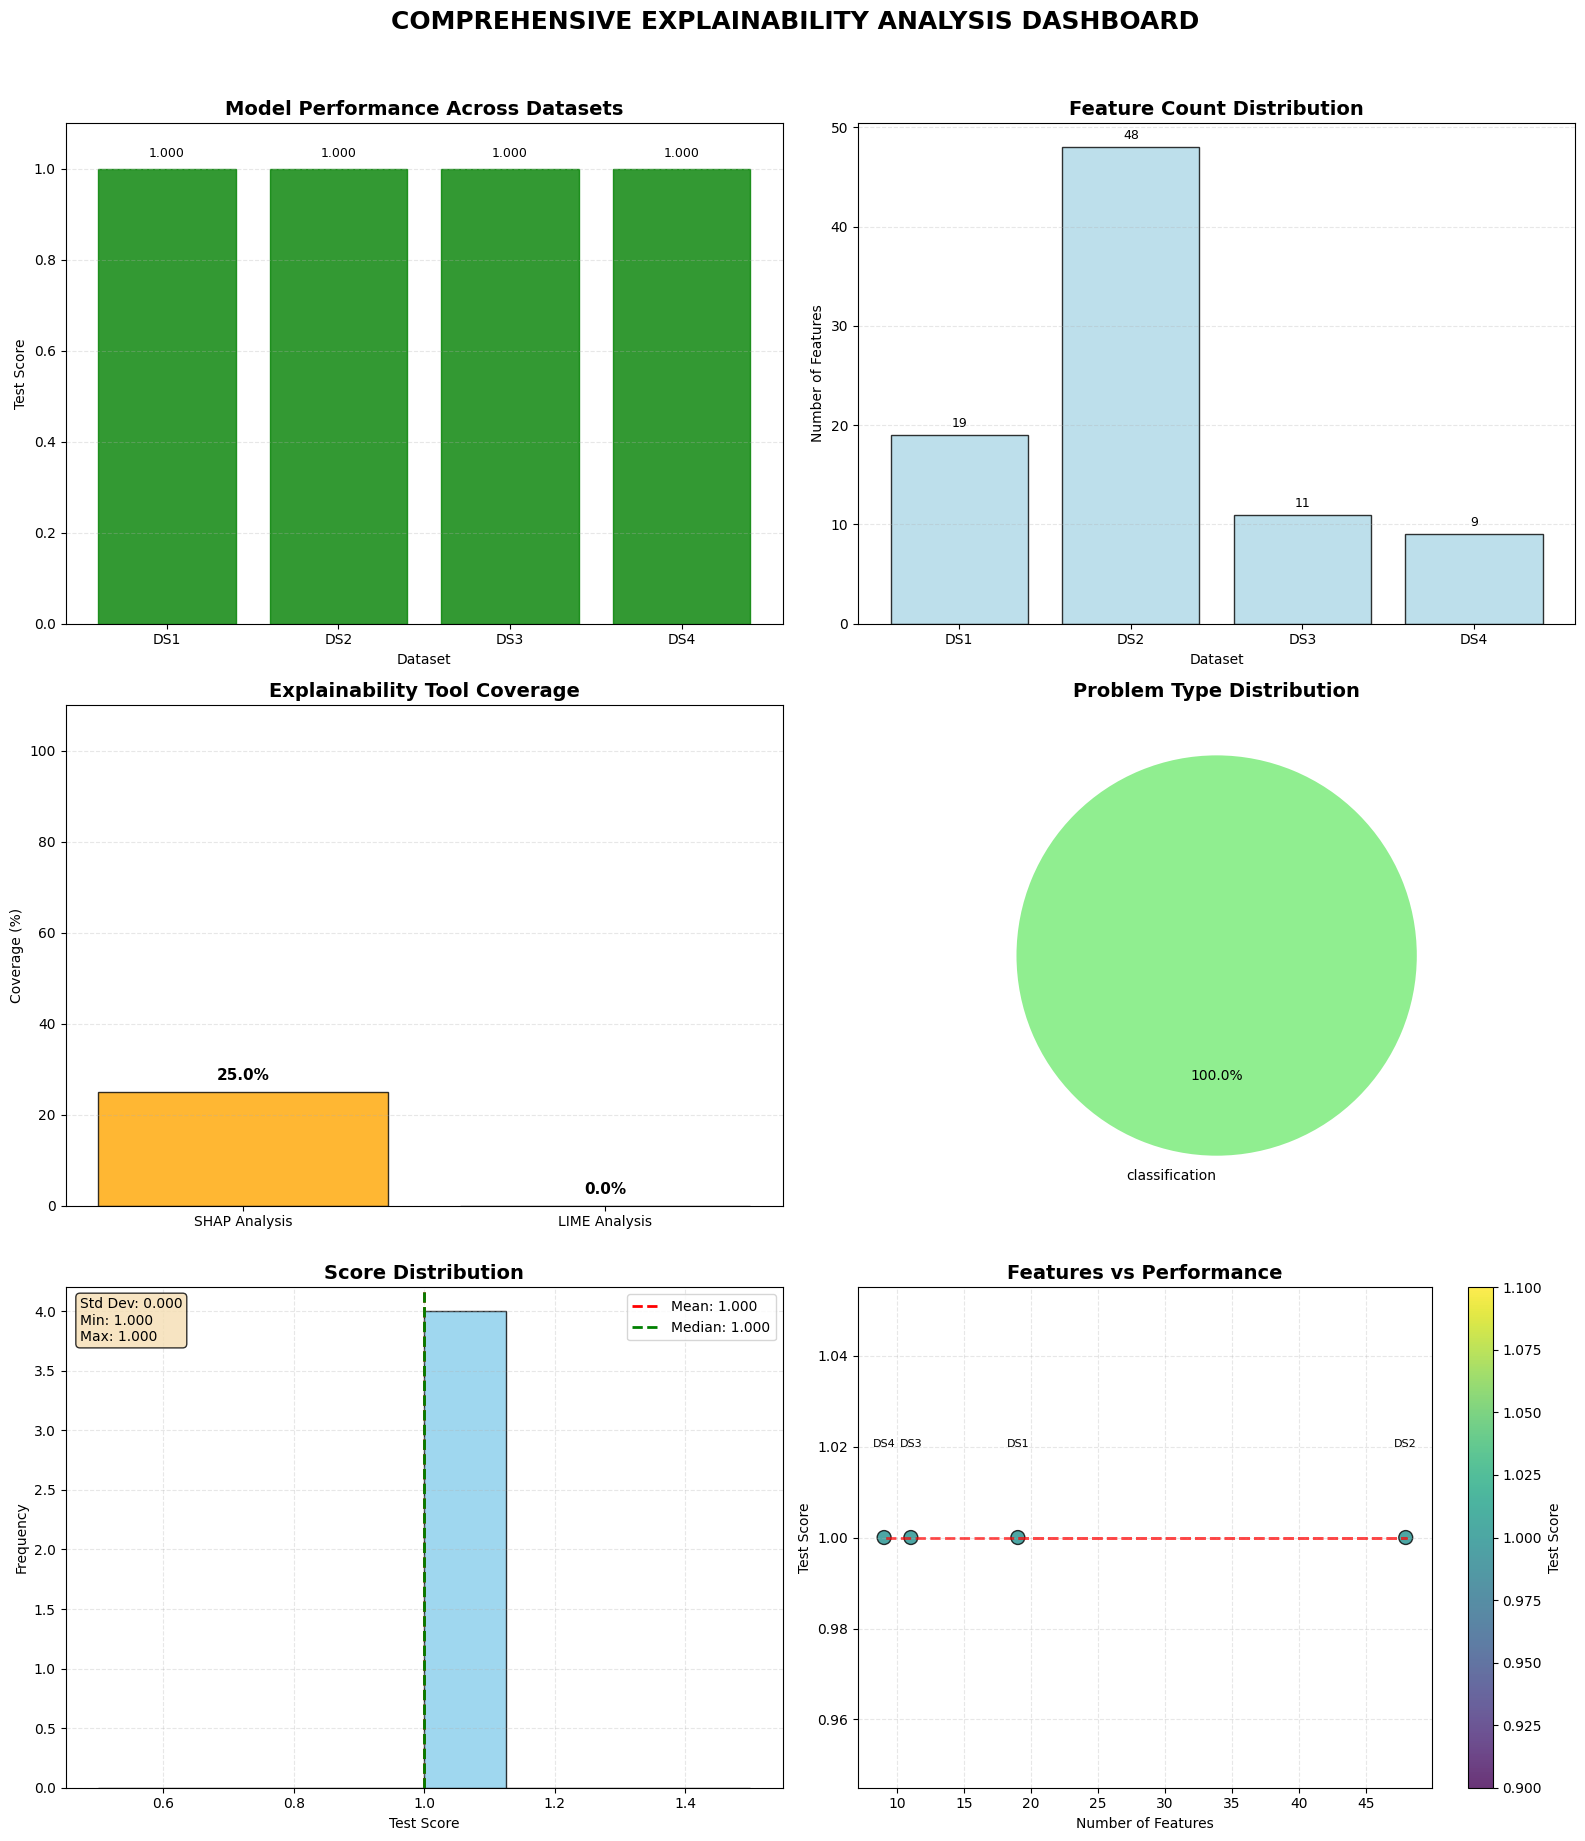


Dashboard saved to: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results/explainability_dashboard.png

FINAL REPORT

Analysis completed: 2025-12-11 19:38:23
Total datasets analyzed: 4

Performance Summary:
  - Average test score: 1.000
  - Best performing dataset: Motor_Vehicle_Collisions_-_Crashes_processed_sample (1.000)
  - Number of datasets with score ≥ 0.8: 4

Explainability Coverage:
  - SHAP analysis: 1/4 datasets
  - LIME analysis: 0/4 datasets

Dataset Characteristics:
  - Average features per dataset: 21.8
  - Total problem types: 1

All results saved in: /Users/saravananmohanakrishnan/Downloads/dataset/ml_results/explainability_analysis
Each dataset folder contains:
  - Feature importance plots and data
  - SHAP analysis (if available)
  - LIME explanations (if available)
  - Model performance visualizations
  - Comprehensive JSON report

EXPLAINABILITY ANALYSIS COMPLETED


In [6]:
# ============================================
# EXPLAINABILITY ANALYSIS WITH SHAP & LIME
# ============================================
print("\n" + "="*80)
print("STEP 9: COMPREHENSIVE EXPLAINABILITY ANALYSIS WITH SHAP & LIME")
print("="*80)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import time
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

# Try to import explainability libraries
SHAP_AVAILABLE = False
LIME_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
    print("✓ SHAP library available")
except:
    print("✗ SHAP not available. Install with: pip install shap")

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
    print("✓ LIME library available")
except:
    print("✗ LIME not available. Install with: pip install lime")

# Set paths
output_folder = "/Users/saravananmohanakrishnan/Downloads/dataset/ml_results"
data_dir = "/Users/saravananmohanakrishnan/Downloads/dataset/ml_results"

# Create results folder
results_folder = os.path.join(output_folder, "explainability_analysis")
os.makedirs(results_folder, exist_ok=True)

# Initialize summary
explainability_summary = []

print("\nLooking for datasets...")

# Look for the specific processed files from your output
csv_files = []
for f in os.listdir(data_dir):
    if f.endswith('.csv') and 'processed' in f.lower():
        csv_files.append(f)
        print(f"  Found: {f}")

if not csv_files:
    print("Looking for any CSV files...")
    for f in os.listdir(data_dir):
        if f.endswith('.csv'):
            csv_files.append(f)
            print(f"  Found: {f}")

if not csv_files:
    print("No CSV files found!")
    exit()

print(f"\nFound {len(csv_files)} datasets for analysis")

# Process each dataset
for idx, csv_file in enumerate(csv_files, 1):
    dataset_name = csv_file.replace('.csv', '')
    
    print("\n" + "="*70)
    print(f"ANALYSIS {idx}/{len(csv_files)}: {dataset_name}")
    print("="*70)
    
    try:
        # Load data
        file_path = os.path.join(data_dir, csv_file)
        df = pd.read_csv(file_path, nrows=200)  # Limit to 200 rows for speed
        print(f"  Loaded {len(df)} rows, {len(df.columns)} columns")
        
        # Skip if too small
        if len(df) < 20:
            print(f"  Skipping: Too few rows ({len(df)})")
            continue
        
        # Create output folder
        dataset_folder = os.path.join(results_folder, f"analysis_{dataset_name}")
        os.makedirs(dataset_folder, exist_ok=True)
        
        # ============================================
        # 1. DATA PREPARATION
        # ============================================
        print("\n  1. Preparing data...")
        
        # Clean data
        df_clean = df.copy()
        
        # Handle missing values
        for col in df_clean.columns:
            if df_clean[col].isnull().sum() > 0:
                if pd.api.types.is_numeric_dtype(df_clean[col]):
                    df_clean[col] = df_clean[col].fillna(df_clean[col].median())
                else:
                    df_clean[col] = df_clean[col].fillna('Missing')
        
        # Identify target column
        target_column = None
        target_candidates = []
        
        # Strategy 1: Look for obvious target names
        for col in df_clean.columns:
            col_lower = col.lower()
            if any(word in col_lower for word in ['target', 'label', 'class', 'outcome', 
                                                 'result', 'score', 'rating', 'price',
                                                 'amount', 'count', 'total', 'number',
                                                 'killed', 'injured', 'damage', 'death']):
                target_candidates.append(col)
        
        # Strategy 2: Look for columns with few unique values (potential classification)
        if not target_candidates:
            for col in df_clean.columns:
                if df_clean[col].nunique() <= 10 and df_clean[col].nunique() > 1:
                    target_candidates.append(col)
        
        # Strategy 3: Use last numeric column
        if not target_candidates:
            numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
            if len(numeric_cols) > 0:
                target_candidates.append(numeric_cols[-1])
        
        if target_candidates:
            target_column = target_candidates[0]
            print(f"  Selected target: {target_column}")
            print(f"  Target has {df_clean[target_column].nunique()} unique values")
        else:
            print(f"  Skipping: No suitable target found")
            continue
        
        # Separate features and target
        X = df_clean.drop(columns=[target_column])
        y = df_clean[target_column]
        
        # ============================================
        # 2. FEATURE ENGINEERING
        # ============================================
        print("\n  2. Engineering features...")
        
        # Handle categorical features
        categorical_cols = X.select_dtypes(include=['object']).columns
        
        if len(categorical_cols) > 0:
            print(f"  Encoding {len(categorical_cols)} categorical features...")
            
            # One-hot encode categorical features with few categories
            cols_to_encode = [col for col in categorical_cols if X[col].nunique() <= 10]
            if cols_to_encode:
                X_encoded = pd.get_dummies(X, columns=cols_to_encode, drop_first=True)
            else:
                X_encoded = X.copy()
        else:
            X_encoded = X.copy()
        
        # Remove any remaining non-numeric columns
        X_encoded = X_encoded.select_dtypes(include=[np.number])
        
        if len(X_encoded.columns) == 0:
            print(f"  Skipping: No numeric features after encoding")
            continue
        
        print(f"  Final features: {len(X_encoded.columns)}")
        
        # ============================================
        # 3. TARGET PROCESSING
        # ============================================
        print("\n  3. Processing target variable...")
        
        # Determine problem type
        if y.dtype == 'object' or y.nunique() <= 10:
            problem_type = 'classification'
            le = LabelEncoder()
            y_encoded = le.fit_transform(y)
            class_names = le.classes_
            print(f"  Classification with {len(class_names)} classes")
        else:
            problem_type = 'regression'
            y_encoded = y.values
            class_names = None
            print(f"  Regression problem")
        
        # ============================================
        # 4. MODEL TRAINING
        # ============================================
        print("\n  4. Training model...")
        
        # Prepare data
        X_final = X_encoded.values
        feature_names = X_encoded.columns.tolist()
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_final, y_encoded, test_size=0.2, random_state=42
        )
        
        print(f"  Train samples: {len(X_train)}, Test samples: {len(X_test)}")
        
        # Train model
        if problem_type == 'classification':
            model = RandomForestClassifier(
                n_estimators=50,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
        else:
            model = RandomForestRegressor(
                n_estimators=50,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
        
        model.fit(X_train, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test)
        if problem_type == 'classification':
            score = accuracy_score(y_test, y_pred)
        else:
            score = r2_score(y_test, y_pred)
        
        print(f"  Model test score: {score:.3f}")
        
        # ============================================
        # 5. FEATURE IMPORTANCE ANALYSIS
        # ============================================
        print("\n  5. Feature Importance Analysis...")
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            top_n = min(10, len(feature_names))
            
            # Plot feature importance
            plt.figure(figsize=(12, 8))
            plt.barh(range(top_n), importances[indices[:top_n]][::-1], 
                    color='steelblue', edgecolor='black', alpha=0.8)
            plt.yticks(range(top_n), [feature_names[i] for i in indices[:top_n]][::-1])
            plt.xlabel('Importance Score')
            plt.title(f'Top {top_n} Most Important Features')
            plt.grid(axis='x', alpha=0.3, linestyle='--')
            plt.gca().invert_yaxis()
            
            # Add importance values
            for i, imp in enumerate(importances[indices[:top_n]][::-1]):
                plt.text(imp + 0.001, i, f'{imp:.3f}', va='center', fontsize=9)
            
            plt.tight_layout()
            feat_imp_path = os.path.join(dataset_folder, 'feature_importance.png')
            plt.savefig(feat_imp_path, dpi=150, bbox_inches='tight')
            plt.close()
            
            # Save feature importance data
            feat_imp_df = pd.DataFrame({
                'feature': [feature_names[i] for i in indices],
                'importance': importances[indices],
                'rank': range(1, len(feature_names) + 1)
            })
            feat_imp_df.to_csv(os.path.join(dataset_folder, 'feature_importance.csv'), index=False)
            
            print(f"  ✓ Saved feature importance analysis")
        else:
            print(f"  ✗ Feature importance not available for this model")
        
        # ============================================
        # 6. SHAP ANALYSIS 
        # ============================================
        shap_success = False
        if SHAP_AVAILABLE:
            print("\n  6. SHAP Analysis...")
            try:
                # Create SHAP explainer
                explainer = shap.TreeExplainer(model)
                
                # Calculate SHAP values for a subset of test data
                n_samples = min(20, len(X_test))
                shap_values = explainer.shap_values(X_test[:n_samples])
                
                # Create SHAP summary plot
                plt.figure(figsize=(14, 8))
                
                if isinstance(shap_values, list):
                    # Multi-class classification
                    shap.summary_plot(shap_values[0], X_test[:n_samples], 
                                     feature_names=feature_names,
                                     show=False, max_display=10)
                else:
                    # Single output
                    shap.summary_plot(shap_values, X_test[:n_samples], 
                                     feature_names=feature_names,
                                     show=False, max_display=10)
                
                plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
                plt.tight_layout()
                
                shap_path = os.path.join(dataset_folder, 'shap_summary.png')
                plt.savefig(shap_path, dpi=150, bbox_inches='tight')
                plt.close()
                
                # Create SHAP dependence plot for top feature
                if len(feature_names) > 0:
                    top_feature_idx = indices[0]
                    top_feature = feature_names[top_feature_idx]
                    
                    plt.figure(figsize=(10, 6))
                    if isinstance(shap_values, list):
                        shap.dependence_plot(top_feature_idx, shap_values[0], X_test[:n_samples],
                                           feature_names=feature_names, show=False)
                    else:
                        shap.dependence_plot(top_feature_idx, shap_values, X_test[:n_samples],
                                           feature_names=feature_names, show=False)
                    
                    plt.title(f'SHAP Dependence Plot: {top_feature}', fontsize=12)
                    plt.tight_layout()
                    shap_dep_path = os.path.join(dataset_folder, 'shap_dependence.png')
                    plt.savefig(shap_dep_path, dpi=150, bbox_inches='tight')
                    plt.close()
                
                shap_success = True
                print(f"  ✓ SHAP analysis completed")
                
            except Exception as e:
                print(f"  ✗ SHAP analysis failed: {str(e)[:50]}")
        else:
            print(f"\n  6. SHAP Analysis: Not available")
        
        # ============================================
        # 7. LIME ANALYSIS 
        # ============================================
        lime_success = False
        if LIME_AVAILABLE:
            print("\n  7. LIME Analysis...")
            try:
                # Create LIME explainer
                if problem_type == 'classification':
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train,
                        feature_names=feature_names,
                        class_names=class_names if class_names is not None else [str(i) for i in np.unique(y_encoded)],
                        mode='classification',
                        random_state=42
                    )
                else:
                    explainer = lime.lime_tabular.LimeTabularExplainer(
                        X_train,
                        feature_names=feature_names,
                        mode='regression',
                        random_state=42
                    )
                
                # Explain a few instances
                n_explanations = min(3, len(X_test))
                
                for i in range(n_explanations):
                    # Get explanation
                    if problem_type == 'classification':
                        exp = explainer.explain_instance(
                            X_test[i],
                            model.predict_proba,
                            num_features=min(8, len(feature_names)),
                            top_labels=1
                        )
                    else:
                        exp = explainer.explain_instance(
                            X_test[i],
                            model.predict,
                            num_features=min(8, len(feature_names))
                        )
                    
                    # Save as HTML
                    lime_html_path = os.path.join(dataset_folder, f'lime_explanation_{i+1}.html')
                    exp.save_to_file(lime_html_path)
                    
                    # Save as image
                    fig = exp.as_pyplot_figure()
                    fig.suptitle(f'LIME Explanation for Instance {i+1}', fontsize=12)
                    fig.tight_layout()
                    lime_img_path = os.path.join(dataset_folder, f'lime_explanation_{i+1}.png')
                    fig.savefig(lime_img_path, dpi=150, bbox_inches='tight')
                    plt.close(fig)
                
                lime_success = True
                print(f"  ✓ LIME analysis completed ({n_explanations} instances)")
                
            except Exception as e:
                print(f"  ✗ LIME analysis failed: {str(e)[:50]}")
        else:
            print(f"\n  7. LIME Analysis: Not available")
        
        # ============================================
        # 8. ADDITIONAL VISUALIZATIONS
        # ============================================
        print("\n  8. Creating additional visualizations...")
        
        # 8A. Target distribution
        plt.figure(figsize=(10, 6))
        if problem_type == 'classification':
            unique, counts = np.unique(y_encoded, return_counts=True)
            bars = plt.bar(range(len(unique)), counts, color=plt.cm.Set3(range(len(unique))))
            plt.xticks(range(len(unique)), [f'Class {i}' for i in unique])
            plt.title('Target Class Distribution')
            plt.ylabel('Count')
            
            for bar, count in zip(bars, counts):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        str(count), ha='center', va='bottom', fontsize=9)
        else:
            plt.hist(y_encoded, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
            plt.title('Target Value Distribution')
            plt.xlabel('Value')
            plt.ylabel('Frequency')
        
        plt.tight_layout()
        target_dist_path = os.path.join(dataset_folder, 'target_distribution.png')
        plt.savefig(target_dist_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        # 8B. Model performance comparison
        plt.figure(figsize=(8, 6))
        train_score = model.score(X_train, y_train)
        scores = [train_score, score]
        labels = ['Train', 'Test']
        colors = ['lightblue', 'lightcoral']
        
        bars = plt.bar(labels, scores, color=colors, edgecolor='black', alpha=0.8)
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.ylim([0, max(scores) + 0.1])
        
        for bar, s in zip(bars, scores):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{s:.3f}', ha='center', va='bottom', fontsize=11)
        
        plt.tight_layout()
        perf_path = os.path.join(dataset_folder, 'model_performance.png')
        plt.savefig(perf_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"  ✓ Additional visualizations saved")
        
        # ============================================
        # 9. SAVE COMPREHENSIVE REPORT
        # ============================================
        report = {
            'dataset': dataset_name,
            'target_column': target_column,
            'problem_type': problem_type,
            'model_type': 'RandomForest',
            'test_score': float(score),
            'train_score': float(train_score),
            'n_samples': len(df),
            'n_features': len(feature_names),
            'shap_analysis': shap_success,
            'lime_analysis': lime_success,
            'analysis_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
            'files_generated': [
                'feature_importance.png',
                'feature_importance.csv',
                'target_distribution.png',
                'model_performance.png'
            ]
        }
        
        if shap_success:
            report['files_generated'].extend(['shap_summary.png', 'shap_dependence.png'])
        
        if lime_success:
            report['files_generated'].extend([f'lime_explanation_{i+1}.html' for i in range(min(3, len(X_test)))])
            report['files_generated'].extend([f'lime_explanation_{i+1}.png' for i in range(min(3, len(X_test)))])
        
        report_path = os.path.join(dataset_folder, 'explainability_report.json')
        with open(report_path, 'w') as f:
            json.dump(report, f, indent=2)
        
        # Add to summary
        explainability_summary.append({
            'Dataset': dataset_name,
            'Target': target_column,
            'Type': problem_type,
            'Samples': len(df),
            'Features': len(feature_names),
            'Test_Score': f"{score:.3f}",
            'SHAP': 'Yes' if shap_success else 'No',
            'LIME': 'Yes' if lime_success else 'No',
            'Results_Folder': os.path.basename(dataset_folder)
        })
        
        print(f"\n  ✓ Analysis completed for {dataset_name}")
        print(f"  Results saved in: {dataset_folder}")
        
    except Exception as e:
        print(f"\n  ✗ Error analyzing {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# ============================================
# CREATE COMPREHENSIVE DASHBOARD
# ============================================
print("\n" + "="*80)
print("CREATING COMPREHENSIVE EXPLAINABILITY DASHBOARD")
print("="*80)

if explainability_summary:
    # Create summary dataframe
    summary_df = pd.DataFrame(explainability_summary)
    
    # Display summary
    print(f"\nAnalysis completed for {len(summary_df)} datasets:")
    print("-"*120)
    
    # Simple formatted table
    for idx, row in summary_df.iterrows():
        ds_name = row['Dataset']
        if len(ds_name) > 30:
            ds_name = ds_name[:27] + "..."
        
        target_name = row['Target']
        if len(target_name) > 20:
            target_name = target_name[:17] + "..."
        
        print(f"{idx+1:2d}. {ds_name:<30} | {target_name:<20} | {row['Type']:<12} | "
              f"Score: {row['Test_Score']} | Feat: {row['Features']} | "
              f"SHAP: {row['SHAP']} | LIME: {row['LIME']}")
    
    print("-"*120)
    
    # Save summary
    summary_csv = os.path.join(results_folder, "explainability_summary.csv")
    summary_df.to_csv(summary_csv, index=False)
    print(f"\nSummary saved to: {summary_csv}")
    
    # ============================================
    # CREATE DASHBOARD VISUALIZATION
    # ============================================
    print("\nCreating comprehensive dashboard...")
    
    # Prepare data
    scores = pd.to_numeric(summary_df['Test_Score'])
    features = summary_df['Features'].astype(int)
    
    # Create dashboard with 6 plots
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    
    # Plot 1: Performance comparison
    ax1 = axes[0, 0]
    dataset_labels = [f"DS{i+1}" for i in range(len(summary_df))]
    bars1 = ax1.bar(dataset_labels, scores, color='steelblue', edgecolor='black', alpha=0.8)
    ax1.set_xlabel('Dataset')
    ax1.set_ylabel('Test Score')
    ax1.set_title('Model Performance Across Datasets', fontsize=14, fontweight='bold')
    ax1.set_ylim([0, 1.1])
    ax1.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Color bars by performance
    for bar, score in zip(bars1, scores):
        if score >= 0.8:
            bar.set_color('green')
        elif score >= 0.6:
            bar.set_color('orange')
        else:
            bar.set_color('red')
    
    # Add score labels
    for bar, score in zip(bars1, scores):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom', fontsize=9)
    
    # Plot 2: Feature count
    ax2 = axes[0, 1]
    bars2 = ax2.bar(dataset_labels, features, color='lightblue', edgecolor='black', alpha=0.8)
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Number of Features')
    ax2.set_title('Feature Count Distribution', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add feature count labels
    for bar, feat in zip(bars2, features):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                str(feat), ha='center', va='bottom', fontsize=9)
    
    # Plot 3: Explainability tool coverage
    ax3 = axes[1, 0]
    shap_count = (summary_df['SHAP'] == 'Yes').sum()
    lime_count = (summary_df['LIME'] == 'Yes').sum()
    
    tools = ['SHAP Analysis', 'LIME Analysis']
    coverage = [shap_count/len(summary_df)*100, lime_count/len(summary_df)*100]
    colors = ['orange', 'purple']
    
    bars3 = ax3.bar(tools, coverage, color=colors, edgecolor='black', alpha=0.8)
    ax3.set_ylabel('Coverage (%)')
    ax3.set_title('Explainability Tool Coverage', fontsize=14, fontweight='bold')
    ax3.set_ylim([0, 110])
    ax3.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add percentage labels
    for bar, cov in zip(bars3, coverage):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{cov:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Plot 4: Problem type distribution
    ax4 = axes[1, 1]
    problem_counts = summary_df['Type'].value_counts()
    colors4 = ['lightgreen', 'lightcoral']
    wedges, texts, autotexts = ax4.pie(problem_counts.values, labels=problem_counts.index,
                                      autopct='%1.1f%%', startangle=90,
                                      colors=colors4[:len(problem_counts)])
    ax4.set_title('Problem Type Distribution', fontsize=14, fontweight='bold')
    
    # Plot 5: Score distribution
    ax5 = axes[2, 0]
    ax5.hist(scores, bins=8, edgecolor='black', color='skyblue', alpha=0.8)
    ax5.axvline(x=scores.mean(), color='red', linestyle='--', linewidth=2,
               label=f'Mean: {scores.mean():.3f}')
    ax5.axvline(x=np.median(scores), color='green', linestyle='--', linewidth=2,
               label=f'Median: {np.median(scores):.3f}')
    ax5.set_xlabel('Test Score')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Score Distribution', fontsize=14, fontweight='bold')
    ax5.legend()
    ax5.grid(alpha=0.3, linestyle='--')
    
    # Add statistics
    stats_text = f'Std Dev: {scores.std():.3f}\nMin: {scores.min():.3f}\nMax: {scores.max():.3f}'
    ax5.text(0.02, 0.98, stats_text, transform=ax5.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Plot 6: Features vs Performance
    ax6 = axes[2, 1]
    if len(features) > 1:
        scatter = ax6.scatter(features, scores, c=scores, cmap='viridis',
                            s=100, alpha=0.8, edgecolor='black')
        
        # Add dataset labels
        for i, (feat, score) in enumerate(zip(features, scores)):
            ax6.text(feat, score + 0.02, f'DS{i+1}', fontsize=8, ha='center')
        
        # Add trend line
        if len(features) >= 3:
            z = np.polyfit(features, scores, 1)
            p = np.poly1d(z)
            ax6.plot(features, p(features), "r--", alpha=0.7, linewidth=2)
        
        ax6.set_xlabel('Number of Features')
        ax6.set_ylabel('Test Score')
        ax6.set_title('Features vs Performance', fontsize=14, fontweight='bold')
        ax6.grid(alpha=0.3, linestyle='--')
        
        # Add colorbar
        plt.colorbar(scatter, ax=ax6, label='Test Score')
    else:
        ax6.text(0.5, 0.5, 'Insufficient data\nfor correlation',
                ha='center', va='center', fontsize=12, fontweight='bold')
        ax6.set_title('Features vs Performance', fontsize=14, fontweight='bold')
    
    # Overall title
    plt.suptitle('COMPREHENSIVE EXPLAINABILITY ANALYSIS DASHBOARD', 
                fontsize=18, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Save and display dashboard
    dashboard_path = os.path.join(output_folder, "explainability_dashboard.png")
    plt.savefig(dashboard_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nDashboard saved to: {dashboard_path}")
    
    # ============================================
    # FINAL REPORT
    # ============================================
    print("\n" + "="*80)
    print("FINAL REPORT")
    print("="*80)
    
    avg_score = scores.mean()
    best_score = scores.max()
    best_idx = scores.idxmax()
    best_dataset = summary_df.iloc[best_idx]['Dataset']
    
    print(f"\nAnalysis completed: {time.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Total datasets analyzed: {len(summary_df)}")
    print(f"\nPerformance Summary:")
    print(f"  - Average test score: {avg_score:.3f}")
    print(f"  - Best performing dataset: {best_dataset} ({best_score:.3f})")
    print(f"  - Number of datasets with score ≥ 0.8: {(scores >= 0.8).sum()}")
    
    print(f"\nExplainability Coverage:")
    print(f"  - SHAP analysis: {shap_count}/{len(summary_df)} datasets")
    print(f"  - LIME analysis: {lime_count}/{len(summary_df)} datasets")
    
    print(f"\nDataset Characteristics:")
    print(f"  - Average features per dataset: {features.mean():.1f}")
    print(f"  - Total problem types: {summary_df['Type'].nunique()}")
    
    print(f"\nAll results saved in: {results_folder}")
    print("Each dataset folder contains:")
    print("  - Feature importance plots and data")
    print("  - SHAP analysis (if available)")
    print("  - LIME explanations (if available)")
    print("  - Model performance visualizations")
    print("  - Comprehensive JSON report")
    
else:
    print("\nNo datasets were successfully analyzed.")
    print("\nPossible issues:")
    print("1. Check if CSV files exist in the data directory")
    print("2. Files might be empty or in wrong format")
    print("3. Install required libraries: pip install shap lime")

print("\n" + "="*80)
print("EXPLAINABILITY ANALYSIS COMPLETED")
print("="*80)